## Imports

In [1]:
# Import lib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import zipfile
import os
import os
import zipfile
import xarray as xr
from tqdm import tqdm
import requests
import time
import json
from typing import Any, Dict, List, Optional, Sequence, Tuple, Union
from tqdm.auto import tqdm
import seaborn as sns
from pathlib import Path

/home/ubuntu/miniconda3/envs/idl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download and extract data

In [2]:
def download_with_progress(url: str, destination: str) -> None:
    """Download a file from `url` to `destination` with a progress bar."""
    response = requests.get(url, stream=True)
    response.raise_for_status()
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 KiB

    with open(destination, 'wb') as f, tqdm(
        total=total_size,
        unit='iB', unit_scale=True,
        desc=f"Downloading {os.path.basename(destination)}",
        ncols=100
    ) as bar:
        for chunk in response.iter_content(block_size):
            f.write(chunk)
            bar.update(len(chunk))


def get_seasfire_datacube(version: str = '0.1') -> Optional[xr.Dataset]:
    """
    Download and extract SeasFire cube for the given version.
    Skips download if the ZIP exists, and skips extraction if the Zarr folder exists.
    """
    try:
        # Determine URLs and filenames
        if version == '0.1':
            url = "https://zenodo.org/records/6834585/files/SeasFireCube8daily.zip"
            zip_filename = "SeasFireCube8daily.zip"
            extracted_folder = 'SeasFireCube8daily.zarr'
        elif version == '0.4':
            url = "https://zenodo.org/records/13834057/files/seasfire_v0.4.zip"
            zip_filename = "seasfire_v0.4.zip"
            extracted_folder = 'seasfire_v0.4.zarr'
        else:
            raise ValueError(f"Unsupported version: {version}")

        # 1) Download step
        if not os.path.exists(zip_filename):
            print(f"⬇Downloading data cube v{version}...")
            download_with_progress(url, zip_filename)
        else:
            print(f"{zip_filename} already exists; skipping download.")

        # 2) Extraction step
        if os.path.isdir(extracted_folder):
            print(f"{extracted_folder} already exists; skipping extraction.")
        else:
            print("Extracting data cube...")
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                members = zip_ref.namelist()
                with tqdm(
                    total=len(members), unit='file', desc='Extracting', ncols=100
                ) as bar:
                    for member in members:
                        if not os.path.exists(member):
                            zip_ref.extract(member)
                        bar.update(1)

        # 3) Verify and load
        if not os.path.isdir(extracted_folder):
            raise FileNotFoundError(f"Extraction failed, '{extracted_folder}' not found.")

        # Decide if consolidated metadata is present
        consolidated = os.path.exists(os.path.join(extracted_folder, '.zmetadata'))
        # Load Zarr store via xarray
        ds = xr.open_zarr(extracted_folder, consolidated=consolidated)
        print("Dataset successfully loaded.")
        return ds

    except Exception as e:
        print(f"An error occurred while downloading or loading the data cube: {e}")
        return None

In [3]:
# Run all download and extraction 
dataset = get_seasfire_datacube(version='0.4')
# # Alternative if already downloaded and extracted
# dataset = xr.open_dataset('seasfire_v0.4.zarr', engine='zarr')

seasfire_v0.4.zip already exists; skipping download.
seasfire_v0.4.zarr already exists; skipping extraction.
Dataset successfully loaded.


In [4]:
# Check if dataset is loaded correctly
dataset
print(dataset['oci_ao'].shape)
print(dataset['fcci_ba'].shape)

(966,)
(966, 720, 1440)


## Data Filtering

In [5]:
def select_spatio_temporal_data(
    data: xr.DataArray | xr.Dataset,
    time_start: int,
    time_length: int,
    latitude: Optional[Union[int, Tuple[int,int]]] = None,
    longitude: Optional[Union[int, Tuple[int,int]]] = None
) -> xr.DataArray | xr.Dataset:
    """
    Slice an xarray object in time (if present), latitude, and longitude.

    Args:
      data        : xarray DataArray or Dataset
      time_start  : start index in 'time' coordinate (ignored if no 'time' dim)
      time_length : number of consecutive timesteps
      latitude    : None (all), int (single index), or (start, end)
      longitude   : None (all), int (single index), or (start, end)

    Returns:
      The subset of `data` with the specified ranges.
    """
    result = data

    # Time slice (only if 'time' exists)
    if 'time' in result.dims:
        result = result.isel(time=slice(time_start, time_start + time_length))

    # Helper to apply a 1D slice on a given dim
    def _apply_slice(ds, dim, key):
        if key is None:
            return ds
        if isinstance(key, int):
            return ds.isel({dim: key})
        if isinstance(key, (list, tuple)) and len(key) == 2:
            return ds.isel({dim: slice(key[0], key[1])})
        raise ValueError(f"{dim!r} must be None, int, or (start,end)")

    # Latitude & Longitude
    result = _apply_slice(result, 'latitude', latitude)
    result = _apply_slice(result, 'longitude', longitude)

    return result


def plot_earth(
    data: xr.DataArray | xr.Dataset,
    time_start: int,
    time_length: int,
    latitude: None | int | tuple[int, int] = None,
    longitude: None | int | tuple[int, int] = None,
    col_wrap: int = 4
) -> None:
    """
    Plot spatio-temporal slices of the data.

    If time_length == 1, plots a single map; otherwise creates a faceted plot over time.
    """
    subset = select_spatio_temporal_data(
        data, time_start, time_length, latitude, longitude
    )

    if time_length == 1:
        subset.plot()
    else:
        subset.plot(
            x="longitude",
            y="latitude",
            col="time",
            col_wrap=col_wrap
        )
    plt.show()


def lat_lon_to_index(
    coords: list[str],
    dim: str,
    size: int
) -> list[int]:
    """
    Convert human-readable lat/lon strings to array indices.

    Args:
      coords : list of strings like '25N', '45W'
      dim    : 'latitude' or 'longitude'
      size   : length of that dimension (e.g. 720 or 1440)
    """
    indices = []
    for val in coords:
        deg = float(val[:-1])
        dirc = val[-1].upper()
        if dim == 'latitude':
            if dirc == 'N':
                idx = int((90 - deg) / 180 * size)
            elif dirc == 'S':
                idx = int((deg + 90) / 180 * size)
            else:
                raise ValueError("Latitude must end with 'N' or 'S'")
        elif dim == 'longitude':
            if dirc == 'E':
                idx = int((deg + 180) / 360 * size)
            elif dirc == 'W':
                idx = int((180 - deg) / 360 * size)
            else:
                raise ValueError("Longitude must end with 'E' or 'W'")
        else:
            raise ValueError("dim must be 'latitude' or 'longitude'")
        indices.append(idx)
    return sorted(indices)

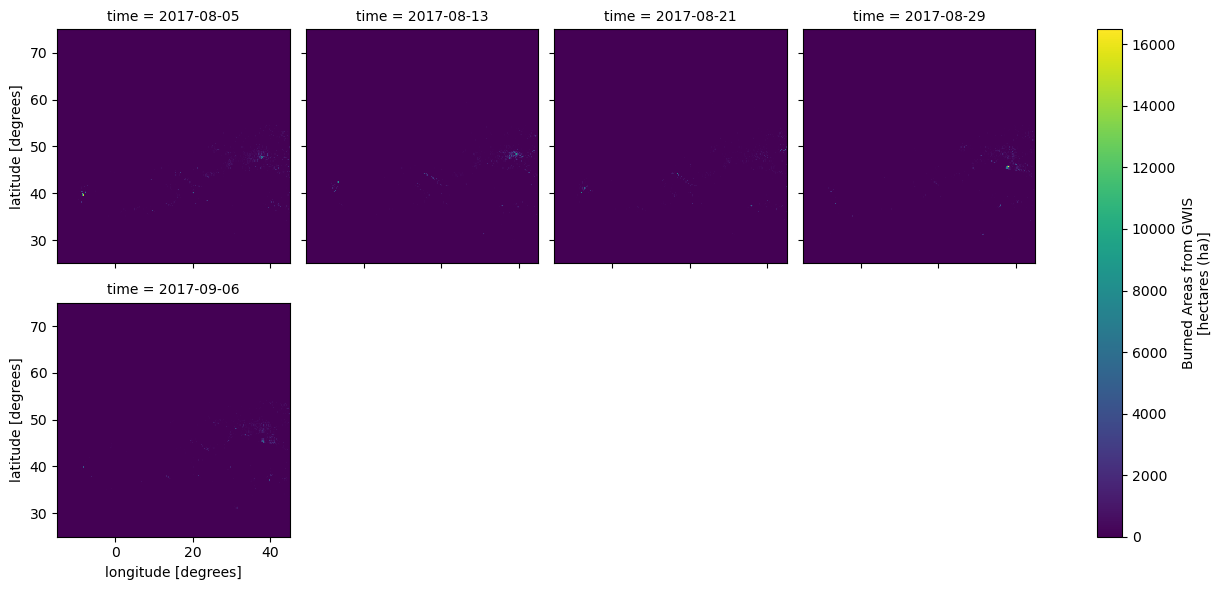

In [6]:
lat_idx = lat_lon_to_index(['25N','75N'], 'latitude', size=720)
lon_idx = lat_lon_to_index(['15W','45E'], 'longitude', size=1440)
plot_earth(dataset['gwis_ba'], 763, 5, latitude=tuple(lat_idx), longitude=tuple(lon_idx))

In [7]:
# disable summarization altogether
np.set_printoptions(threshold=np.inf)

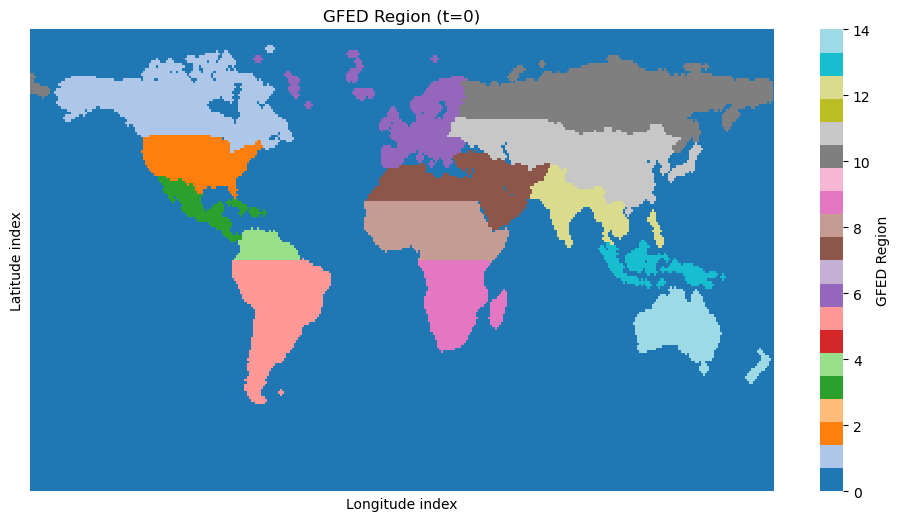

In [8]:
# Plot GFED region
# grab the first time‐slice as a 2D numpy array
data2d = dataset['gfed_region'].values

plt.figure(figsize=(12, 6))
sns.heatmap(data2d,
            cmap='tab20',        # or any matplotlib colormap you like
            cbar_kws={'label': 'GFED Region'},
            xticklabels=False,    # turn off to keep it fast
            yticklabels=False)
plt.title('GFED Region (t=0)')
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.show()

/tmp/ipykernel_3031/4159122535.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lat_idx = lat_lon_to_index(lat_bounds, 'latitude', size=dataset.dims['latitude'])
/tmp/ipykernel_3031/4159122535.py:8: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lon_idx = lat_lon_to_index(lon_bounds, 'longitude', size=dataset.dims['longitude'])
/tmp/ipykernel_3031/4159122535.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please u

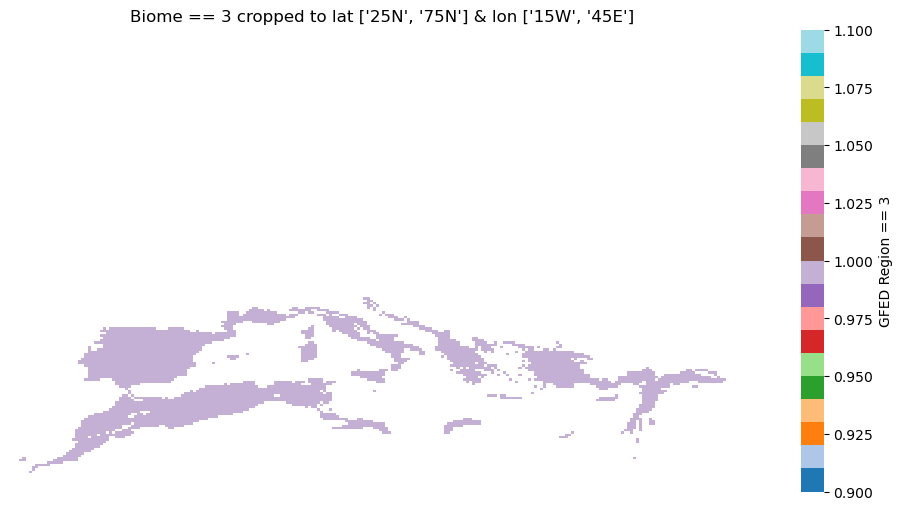

In [9]:
# 1) Build a mask (1 where biome==3, NaN elsewhere)
mask3 = (dataset.biomes == 3).astype(float).where(dataset.biomes == 3)

# 2) Define your bounds in human form…
lat_bounds = ['25N', '75N']
lon_bounds = ['15W', '45E']
lat_idx = lat_lon_to_index(lat_bounds, 'latitude', size=dataset.dims['latitude'])
lon_idx = lat_lon_to_index(lon_bounds, 'longitude', size=dataset.dims['longitude'])

# 3) Convert to index‐pairs
lat_idx = lat_lon_to_index(
    coords=lat_bounds,
    dim='latitude',
    size=dataset.dims['latitude']
)
lon_idx = lat_lon_to_index(
    coords=lon_bounds,
    dim='longitude',
    size=dataset.dims['longitude']
)

# 4) Extract the [t=0] subcube:
subset = select_spatio_temporal_data(
    data        = mask3,
    time_start  = 0,
    time_length = 1,
    latitude    = (lat_idx[0], lat_idx[1]),
    longitude   = (lon_idx[0], lon_idx[1])
)

subset = select_spatio_temporal_data(mask3, 763, 1, latitude=tuple(lat_idx), longitude=tuple(lon_idx))

# 5) Plot:
plt.figure(figsize=(12, 6))
sns.heatmap(
    subset.values,
    cmap='tab20',
    cbar_kws={'label': 'GFED Region == 3'},
    xticklabels=False,
    yticklabels=False
)
plt.title(f"Biome == 3 cropped to lat {lat_bounds} & lon {lon_bounds}")
plt.show()

# # 6) Plot 2 ???:
# print("Subset shape (t, lat, lon):", subset.shape)
# arr_1d = subset.values.ravel()

# # 4) Plot histogram (log‐y)
# plt.figure(figsize=(8, 4))
# plt.hist(arr_1d, bins=50, log=True)
# plt.title("Histogram of Burnt Area Values\n(t=0–99, lat/lon slice)")
# plt.xlabel("Value")
# plt.ylabel("Frequency (log scale)")
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()

In [10]:
dataset

<xarray.Dataset> Size: 164GB
Dimensions:                         (latitude: 720, longitude: 1440, time: 966)
Coordinates:
  * latitude                        (latitude) float64 6kB 89.88 ... -89.88
  * longitude                       (longitude) float64 12kB -179.9 ... 179.9
  * time                            (time) datetime64[ns] 8kB 2001-01-01 ... ...
Data variables: (12/59)
    area                            (latitude, longitude) float32 4MB ...
    biomes                          (latitude, longitude) float32 4MB nan ......
    cams_co2fire                    (time, latitude, longitude) float32 4GB ...
    cams_frpfire                    (time, latitude, longitude) float32 4GB ...
    drought_code_max                (time, latitude, longitude) float32 4GB ...
    drought_code_mean               (time, latitude, longitude) float32 4GB ...
    ...                              ...
    t2m_max                         (time, latitude, longitude) float32 4GB ...
    t2m_mean                        (time, latitude, longitude) float32 4GB ...
    t2m_min                         (time, latitude, longitude) float32 4GB ...
    tp                              (time, latitude, longitude) float32 4GB ...
    vpd                             (time, latitude, longitude) float32 4GB ...
    ws10                            (time, latitude, longitude) float32 4GB ...
Attributes:
    crs:          EPSG:4326
    description:  The SeasFire Cube is a scientific datacube for seasonal fir...
    title:        SeasFire Cube: A Global Dataset for Seasonal Fire Modeling ...

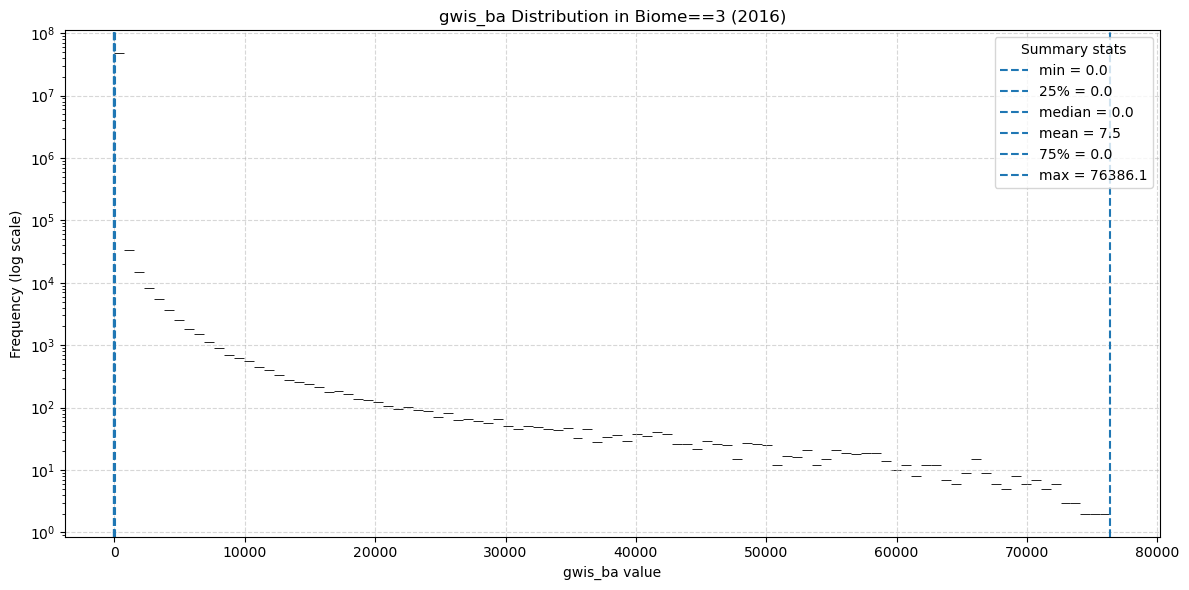

In [11]:
# Burn area distribution (sample: biomes==3, 2016)
year = 2016
gwis = dataset['gwis_ba'].sel(time=slice(f'{year}-01-01', f'{year}-12-31'))

# Apply the spatial mask across all timesteps
#    -> shape becomes (time, lat, lon) but only with biome==3 locations kept
gwis3 = gwis.where(mask3)

# Flatten to 1D and drop the NaNs
flat = gwis3.values.ravel()
flat = flat[~np.isnan(flat)]

# Stats
stats = {
    'min':   np.min(flat),
    '25%':   np.percentile(flat, 25),
    'median':np.percentile(flat, 50),
    'mean':  np.mean(flat),
    '75%':   np.percentile(flat, 75),
    'max':   np.max(flat),
}


# Plot histogram
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(
    flat,
    bins=100,
    stat='count',
    log_scale=(False, True),
    ax=ax,
    color='lightgray'
)

# Overlay lines + annotate
ylim = ax.get_ylim()[1]
for name, val in stats.items():
    ax.axvline(val, linestyle='--', label=f"{name} = {val:.1f}")
    
# Place a legend outside
ax.legend(loc='upper right', title='Summary stats')

# 5) Final touches
ax.set_title(f"gwis_ba Distribution in Biome==3 ({year})")
ax.set_xlabel("gwis_ba value")
ax.set_ylabel("Frequency (log scale)")
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Generate the train/val/test .json files under data folder

### Helper functions

In [12]:
def flatten_coords(
    coords: np.ndarray,
    shape: Tuple[int, int, int]
) -> np.ndarray:
    """Convert (t, y, x) coords → flat indices."""
    return np.ravel_multi_index(coords.T, dims=shape, order='C')


def unflatten_coords(
    flat: np.ndarray,
    shape: Tuple[int, int, int]
) -> np.ndarray:
    """
    Convert flat indices → array of (t, y, x) coords.
    """
    # NOTE: pass `shape` as a positional arg, not `dims=`
    unraveled = np.unravel_index(flat, shape, order='C')
    return np.column_stack(unraveled)


def sample_new_coords(
    shape: Tuple[int, int, int],
    exclude: np.ndarray,
    N: int,
    mask2d: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Randomly sample N unique (t,y,x) coords in an array of shape `shape`,
    excluding any in `exclude`, and (optionally) only where `mask2d==1`.
    """
    n_t, n_y, n_x = shape
    total = n_t * n_y * n_x

    # 1) build valid flat pool
    all_flat = np.arange(total)
    if mask2d is not None:
        # only allow flats whose spatial part is in mask
        spatial_size = n_y * n_x
        spatial_flat = all_flat % spatial_size
        valid_spatial = mask2d.flatten(order='C').astype(bool)
        valid_flat = all_flat[valid_spatial[spatial_flat]]
    else:
        valid_flat = all_flat

    # 2) exclude already‐used
    if exclude.size:
        exclude_flat = flatten_coords(exclude, shape)
        valid_flat = np.setdiff1d(valid_flat, exclude_flat, assume_unique=True)

    # 3) ensure enough room
    if N > valid_flat.size:
        raise ValueError(f"Cannot sample {N} coords; only {valid_flat.size} valid.")

    # 4) sample and unflatten
    picked = np.random.choice(valid_flat, size=N, replace=False)
    return unflatten_coords(picked, shape)


def get_time_range(
    mode: str,
    time_lag: int,
    step_size: int = 46
) -> Tuple[int, int]:
    """
    Return (start, length) for train/test/val splits.
    Default step_size=46 (≈8-day windows per year).
    """
    if mode == 'train':
        return 0, step_size * 17
    if mode == 'test':
        return step_size * 17, step_size * 2
    if mode == 'val':
        return step_size * 19, step_size * 2
    if mode == 'matrix':
        return 0, step_size * 19
    raise ValueError("mode must be 'train', 'test', 'val', 'matrix")


def load_variable_arrays(
    ds: xr.Dataset,
    var_names: Sequence[str],
    time_start: int,
    time_len: int,
    lat_slice: Optional[Tuple[int,int]] = None,
    lon_slice: Optional[Tuple[int,int]] = None
) -> Dict[str, np.ndarray]:
    """
    Extract variables from ds into NumPy arrays, slicing only
    over dims that actually exist.

    - time: slice(time_start, time_start+time_len) if present
    - latitude: slice(lat_slice) if present and lat_slice is not None
    - longitude: slice(lon_slice) if present and lon_slice is not None
    """
    arrays: Dict[str, np.ndarray] = {}
    t_sel = slice(time_start, time_start + time_len)

    for v in var_names:
        da = ds[v]

        # 1) time slice if it exists
        if "time" in da.dims:
            da = da.isel(time=t_sel)

        # 2) latitude slice if requested and exists
        if lat_slice is not None and "latitude" in da.dims:
            da = da.isel(latitude=slice(lat_slice[0], lat_slice[1]))

        # 3) longitude slice if requested and exists
        if lon_slice is not None and "longitude" in da.dims:
            da = da.isel(longitude=slice(lon_slice[0], lon_slice[1]))

        arrays[v] = da.values

    return arrays


def get_positive_negative_coords(
    fire_arr: np.ndarray,
    safe_threshold: float,
    fire_threshold: float,
    negative_ratio: int,
    time_lag: int,
    mask2d: Optional[np.ndarray] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Positive: first t where fire_arr[t] > fire_threshold AND
              all fire_arr[t-time_lag : t] < safe_threshold.
    Negative: any t where fire_arr[t-time_lag : t] < safe_threshold.

    Returns (pos_coords, neg_coords) with shape (N,3) tuples (t,y,x).
    """
    T, Y, X = fire_arr.shape
    pos_list: List[Tuple[int,int,int]] = []
    neg_cands: List[Tuple[int,int]] = []

    # 1) find positives and eligible negative cells
    for y in range(Y):
        for x in range(X):
            series = fire_arr[:, y, x]
            series_filled = np.nan_to_num(series, nan=-np.inf)

            # find first crossing above fire_threshold
            above = np.where(series_filled > fire_threshold)[0]
            if above.size:
                t0 = int(above[0])
                if t0 >= time_lag:
                    history = series_filled[t0-time_lag : t0]
                    if np.all(history < safe_threshold):
                        pos_list.append((t0, y, x))
            else:
                neg_cands.append((y, x))

    pos_coords = np.array(pos_list, dtype=int)
    n_pos = len(pos_coords)

    # 2) sample negatives with random t ensuring the whole  window < safe_threshold
    required_neg = negative_ratio * n_pos
    neg_list: List[Tuple[int,int,int]] = []
    rng = np.random.default_rng(0)

    # build flat exclude mask if desired (we’ll just avoid overlapping below)
    while len(neg_list) < required_neg:
        y, x = neg_cands[rng.integers(len(neg_cands))]
        t0 = rng.integers(time_lag, T)
        window = fire_arr[t0-time_lag : t0, y, x]
        if np.all(np.nan_to_num(window, nan=np.inf) < safe_threshold):
            neg_list.append((t0, y, x))

    neg_coords = np.array(neg_list, dtype=int)
    return pos_coords, neg_coords



In [13]:
def build_instances(
    pos_coords: np.ndarray,
    neg_coords: np.ndarray,
    local_vars: Dict[str, np.ndarray],
    oci_vars: Dict[str, np.ndarray],
    time_lag: int,
    initial_t: int
) -> List[Dict[str, Any]]:
    """
    Build the list of JSON objects from positive/negative coords and variable arrays.
    """
    out: List[Dict[str, Any]] = []
    for coords, label in ((pos_coords, 1), (neg_coords, 0)):
        desc = 'pos' if label else 'neg'
        for (t_rel, y, x) in tqdm(coords, desc=f"Processing {desc}", unit='pt'):
            t_abs   = initial_t + time_lag + int(t_rel)
            rel_idx = t_abs - initial_t
            t0, t1  = rel_idx - time_lag, rel_idx

            inst = {'local_variables': {}, 'ocis': {}, 'target': label}

            # Spatial vars (time, y, x)
            for var, arr in local_vars.items():
                key = var.upper()
                inst['local_variables'][key] = arr[t0:t1, y, x].tolist()

            # OCI vars: either (time,y,x) or (time,)
            for var, arr in oci_vars.items():
                key = var.upper()
                if arr.ndim == 3:
                    # same indexing as local
                    inst['ocis'][key] = arr[t0:t1, y, x].tolist()
                elif arr.ndim == 1:
                    # purely temporal → drop spatial
                    inst['ocis'][key] = arr[t0:t1].tolist()
                else:
                    raise ValueError(f"Unexpected array shape for {var}: {arr.shape}")

            out.append(inst)

    np.random.shuffle(out)
    return out


def remove_temporal_overlaps(
    coords: np.ndarray,
    time_lag: int,
    max_overlap: float = 0.0
) -> np.ndarray:
    """
    For each spatial cell (y,x), greedily keep coords whose
    [t_rel-time_lag … t_rel] windows overlap that same cell’s
    already‐selected windows by at most max_overlap fraction.
    Samples in different cells are never compared.
    """
    allowed = int(max_overlap * time_lag)
    kept = []

    # Group by (y,x)
    from collections import defaultdict
    cell_groups = defaultdict(list)
    for t, y, x in coords:
        cell_groups[(y,x)].append(int(t))

    # Process each cell individually
    for (y,x), ts in cell_groups.items():
        windows = []
        for t in sorted(ts):
            start, end = t-time_lag, t
            # check against this cell’s windows only
            if all((min(end, e0) - max(start, s0) + 1) <= allowed
                   for (s0,e0) in windows):
                windows.append((start,end))
                kept.append((t, y, x))

    return np.array(kept, dtype=int)


def build_dataset(
    ds: xr.Dataset,
    mode: str = 'train',
    latitude_bounds: List[str] = ['25N', '75N'],
    longitude_bounds: List[str] = ['15W', '45E'],
    negative_ratio: int = 5,
    safe_threshold: float = 1000,
    fire_threshold: float = 20000,
    time_lag: int = 39,
    max_overlap: float = 0.0,
    fire_var: str = 'gwis_ba',
    local_vars: Tuple[str,...] = ("t2m_mean", "tp", "vpd"),
    oci_vars: Tuple[str,...] = ("oci_nao", "oci_nina34_anom", "oci_ao"),
    mask2d: Optional[np.ndarray] = None,
    out_path: Union[str, Path] = "./data"
) -> Path:
    """
    Build and save a dataset (NDJSON) of positive/negative fire examples.

    Returns the path to the written `.json` file.
    """
    # 0) check keys
    required = (fire_var,) + local_vars + oci_vars
    missing = [k for k in required if k not in ds]
    if missing:
        raise KeyError(f"Missing variables in dataset: {missing}")

    # 1) time ranges
    initial_t, total_steps = get_time_range(mode, time_lag)
    core_start = initial_t + time_lag
    core_len   = total_steps - time_lag

    # 2) spatial slices
    lat_idx = lat_lon_to_index(latitude_bounds, 'latitude', ds.dims['latitude'])
    lon_idx = lat_lon_to_index(longitude_bounds, 'longitude', ds.dims['longitude'])
    lat_slice = (lat_idx[0], lat_idx[1])
    lon_slice = (lon_idx[0], lon_idx[1])

    # 3) load arrays
    fire_arr = load_variable_arrays(
        ds, [fire_var],
        time_start=initial_t+time_lag,
        time_len=total_steps-time_lag,
        lat_slice=lat_slice,
        lon_slice=lon_slice
    )[fire_var]
    local_arrs = load_variable_arrays(ds, local_vars, initial_t, total_steps, lat_slice, lon_slice)
    oci_arrs   = load_variable_arrays(ds, oci_vars, initial_t, total_steps, lat_slice, lon_slice)

    # 4) sample according to new rules
    pos_coords, neg_coords = get_positive_negative_coords(
        fire_arr,
        safe_threshold,
        fire_threshold,
        negative_ratio,
        time_lag,
        mask2d
    )

    # 5) enforce max_overlap on both
    pos_coords = remove_temporal_overlaps(pos_coords, time_lag, max_overlap)
    neg_coords = remove_temporal_overlaps(neg_coords, time_lag, max_overlap)

    # 6) build JSON instances (unchanged)
    instances = build_instances(
        pos_coords, neg_coords,
        local_vars=local_arrs,
        oci_vars=oci_arrs,
        time_lag=time_lag,
        initial_t=initial_t
    )

    # 7) write NDJSON to disk
    out_dir = Path(out_path); out_dir.mkdir(exist_ok=True, parents=True)
    out_file = out_dir / f"{mode}.json"
    with out_file.open('w', encoding='utf-8') as f:
        for inst in instances:
            f.write(json.dumps(inst, ensure_ascii=False) + "\n")

    print(f"Saved {len(instances)} samples to {out_file}")
    return out_file


### Main builder

### JSON file generator

Fire data is continuous variable. The fire_threshold can transform the continuous fire area variable to the binary status. Smaller fire_threshold, larger .json file created.

In [18]:
# For real implementation, suggest the fire_threshold to be 1.
dataset = xr.open_dataset('seasfire_v0.4.zarr', engine='zarr')

parition = ['train', 'val', 'test', 'matrix']

json_paths = {}
for par in parition:
    print(f"\nBuilding {par} partition")
    json_paths[par] = build_dataset(
        ds=dataset,
        mode=par,
        fire_threshold=5,
        safe_threshold=1,
        max_overlap=0.3,
    )

print("\nGenerated files:")
for par, path in json_paths.items():
    print(f"\n{par}: {path}")


Building train partition


/tmp/ipykernel_3031/482127536.py:112: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lat_idx = lat_lon_to_index(latitude_bounds, 'latitude', ds.dims['latitude'])
/tmp/ipykernel_3031/482127536.py:113: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  lon_idx = lat_lon_to_index(longitude_bounds, 'longitude', ds.dims['longitude'])
Processing neg: 100%|██████████| 33728/33728 [00:01<00:00, 28581.14pt/s]


Saved 40744 samples to data/train.json

Building val partition


Processing neg: 100%|██████████| 2378/2378 [00:00<00:00, 60963.12pt/s]


Saved 2866 samples to data/val.json

Building test partition


Processing neg: 100%|██████████| 2318/2318 [00:00<00:00, 59103.79pt/s]


Saved 2793 samples to data/test.json

Building matrix partition


Processing neg: 100%|██████████| 35907/35907 [00:01<00:00, 27359.21pt/s]


Saved 43353 samples to data/matrix.json

Generated files:

train: data/train.json

val: data/val.json

test: data/test.json

matrix: data/matrix.json
